# Chapter: Finding Groups in Process Data: Clustering & Mixture Modeling

# Topic: GMM algorithm 

In [1]:
##%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                          GMM clustering of Etch data
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [2]:
# import required packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

In [3]:
# fetch data
import scipy.io

matlab_data = scipy.io.loadmat('MACHINE_Data.mat', struct_as_record = False)
Etch_data = matlab_data['LAMDATA']
calibration_dataAll = Etch_data[0,0].calibration # calibration_dataAll[i,0] corresponds to a 2D data from ith batch where columns correspond to different variables 

variable_names = Etch_data[0,0].variables

In [4]:
##%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                          perform Multiway PCA
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [5]:
# generate unfolded data matrix
n_vars = variable_names.size - 2 # first 2 columns are not process variables
n_samples = 85 # following the work of He et al.

unfolded_dataMatrix = np.empty((1,n_vars*n_samples))
for expt in range(calibration_dataAll.size):
    calibration_expt = calibration_dataAll[expt,0][5:90,2:] # removing first 5 measurements as done in He et al.
    
    if calibration_expt.shape[0] < 85:
        continue
    
    unfolded_row = np.ravel(calibration_expt, order='F')[np.newaxis,:]
    unfolded_dataMatrix = np.vstack((unfolded_dataMatrix, unfolded_row))

unfolded_dataMatrix = unfolded_dataMatrix[1:,:]

In [6]:
# scale data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_train_normal = scaler.fit_transform(unfolded_dataMatrix)

In [7]:
# PCA
from sklearn.decomposition import PCA

pca = PCA(n_components = 3) # following the work of He et al.
score_train = pca.fit_transform(data_train_normal)

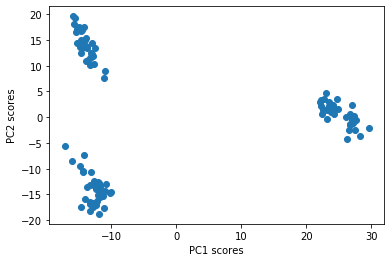

In [8]:
# visualize in 2D
plt.figure()
plt.scatter(score_train[:,0],score_train[:,1])
plt.xlabel('PC1 scores')
plt.ylabel('PC2 scores')
plt.show()

In [9]:
##%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                          GMM on PCA scores
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

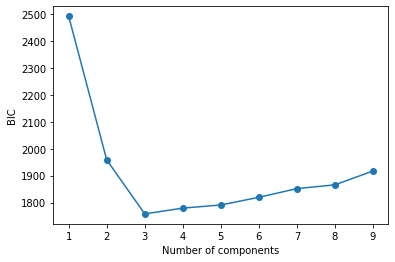

In [10]:
# finding # of components via BIC 
BICs = []
lowestBIC = np.inf
for n_cluster in range(1, 10):
    gmm = GaussianMixture(n_components = n_cluster, random_state = 100)
    gmm.fit(score_train)
    BIC = gmm.bic(score_train)
    BICs.append(BIC)
    
    if BIC < lowestBIC:
        optimal_n_cluster = n_cluster 
        lowestBIC = BIC

plt.figure()
plt.plot(range(1,10), BICs, marker='o')
plt.xlabel('Number of components')
plt.ylabel('BIC')
plt.show()

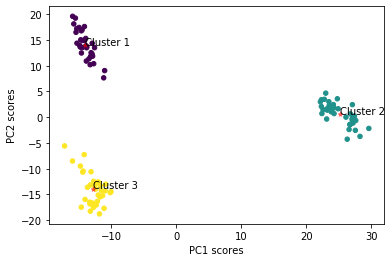

In [11]:
# fit GMM model to metal-etch data
gmm = GaussianMixture(n_components = optimal_n_cluster, random_state = 100)
cluster_label = gmm.fit_predict(score_train)

plt.figure()
plt.scatter(score_train[:, 0], score_train[:, 1], c = cluster_label, s=20, cmap='viridis')
plt.xlabel('PC1 scores')
plt.ylabel('PC2 scores')

cluster_centers = gmm.means_
cluster_plot_labels = ['Cluster ' + str(i+1) for i in range(optimal_n_cluster)]
for i in range(optimal_n_cluster):
    plt.scatter(cluster_centers[i, 0], cluster_centers[i, 1], c='red', s=20, marker = '*', alpha=0.5)
    plt.annotate(cluster_plot_labels[i], (cluster_centers[i,0], cluster_centers[i,1]))

plt.show()